In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import math
import random
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.applications import EfficientNetB0, vgg16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# 1. Transfer Learning for Image Classification1
# It is highly recommended that you complete this project using Keras2 and Python.

## (a) In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. You are provided with text data in twenty folders

> Data has been downloaded from the Folder.

## (b) Data Exploration and Pre-processing

### i. Images in each class are given in separate folders. The file Classes.xlsx provides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and Classes.xlsx.
### ii. Randomly select ⌈0.7ni⌉ images from each folder as your training set, ⌈0.15ni⌉ as validation set, and the rest as your test set, where ni is the number of images in folder i and ⌈x⌉ is the ceiling of x.
### iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [2]:
classes = pd.read_excel("../data/Classes.xlsx", names=['folder', 'class'])
classes['folder'] = classes['folder'].str.split('.').str[1]

In [3]:
memcache = classes.set_index('folder').T.to_dict('list')
memcache = dict((k.lower(), v) for k, v in memcache.items())

In [4]:
dirpath = '../data/images'
for foldername in os.listdir(dirpath):
    if foldername == ".DS_Store": continue
    temp = []
    for filename in os.listdir(os.path.join(dirpath, foldername)):
        temp.append(os.path.join(dirpath,foldername,filename))
    memcache[foldername.split('.')[1].lower()].append(temp)
    
split_cache = {}
train_images, train_labels, validation_images, validation_labels, test_images, test_labels = [], [], [], [], [], []
shape = (200, 200)
for key, values in memcache.items():
    length = len(values[1])
    indices = set([i for i in range(length)])
    train_indices = random.sample(list(indices), math.ceil(0.7*len(indices)))
    indices = indices - set(train_indices)
    validation_indices = random.sample(list(indices), math.ceil(0.15*len(indices)))
    indices = indices - set(validation_indices)
    split_cache[key] = (train_indices, validation_indices, indices)
    
    images = np.array(values[1])
    train_images.extend(images[train_indices])
    train_labels.extend([[values[0]] for _ in train_indices])
    validation_images.extend(images[validation_indices])
    validation_labels.extend([[values[0]] for _ in validation_indices])
    test_images.extend(images[list(indices)])
    test_labels.extend([[values[0]] for _ in indices])
# train_images = [cv2.imread(os.path.join(path)) for path in train_images]
# train_images = [cv2.resize(img, shape) for img in train_images]
# validation_images = [cv2.imread(os.path.join(path)) for path in validation_images]
# validation_images = [cv2.resize(img, shape) for img in validation_images]
# test_images = [cv2.imread(os.path.join(path)) for path in test_images]
# test_images = [cv2.resize(img, shape) for img in test_images]
train_df = pd.DataFrame({'Images': train_images, 'Class': train_labels})
# temp = [x[0] for x in train_df['Class']]
# train_df['Class'] = temp
# train_df = train_df.sample(frac=1, ignore_index = True)
validation_df = pd.DataFrame({'Images': validation_images, 'Class': validation_labels})
# temp = [x[0] for x in validation_df['Class']]
# validation_df['Class'] = temp
# validation_df = validation_df.sample(frac=1, ignore_index = True)
test_df = pd.DataFrame({'Images': test_images, 'Class': test_labels})
# temp = [x[0] for x in test_df['Class']]
# test_df['Class'] = temp
# test_df = test_df.sample(frac=1, ignore_index = True)

print(len(train_images))
print(len(validation_images))
print(len(test_images))
print(len(train_images) == len(train_labels))
print(len(validation_images) == len(validation_labels))
print(len(test_images) == len(test_labels))
plt.imshow(train_images[69])

## (c) Transfer Learning

### i. When dealing with classification of relatively small image datasets, deep net- works may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those fea- tures can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement lay- ers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained mod- els EfficientNetB0 and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

### ii. To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

### iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

### iv. Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [5]:
train_df

,Images,Class
0,../data/images/005.Crested_Auklet/Crested_Aukl...,[0]
1,../data/images/005.Crested_Auklet/Crested_Aukl...,[0]
2,../data/images/005.Crested_Auklet/Crested_Aukl...,[0]
3,../data/images/005.Crested_Auklet/Crested_Aukl...,[0]
4,../data/images/005.Crested_Auklet/Crested_Aukl...,[0]
...,...,...
822,../data/images/168.Kentucky_Warbler/Kentucky_W...,[19]
823,../data/images/168.Kentucky_Warbler/Kentucky_W...,[19]
824,../data/images/168.Kentucky_Warbler/Kentucky_W...,[19]
825,../data/images/168.Kentucky_Warbler/Kentucky_W...,[19]


In [6]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rescale=1./255,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
validate_filenames=False,
dataframe = train_df, 
directory = '',
x_col = 'Images',
y_col = 'Class',
class_mode = 'categorical',
batch_size = 20,
target_size=(224,224))


test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_dataframe(
validate_filenames=False,
dataframe = validation_df,
directory = '',
x_col = 'Images',
y_col = 'Class',
class_mode = 'categorical',
batch_size = 20,
target_size=(224,224))

Found 827 non-validated image filenames belonging to 20 classes.
Found 59 non-validated image filenames belonging to 20 classes.


In [14]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()
 

In [12]:
eff_conv = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
for layer in eff_conv.layers[:-1]:
    layer.trainable = False
for layer in eff_conv.layers:
    print(layer, layer.trainable)
filepath = 'efficient_b0_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
es = es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model = Sequential()
model.add(vgg_conv)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(20, activation='softmax'))
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])
 
model.summary()

16705208/16705208 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7fd190707e50> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fd1c15677c0> False
<keras.layers.preprocessing.normalization.Normalization object at 0x7fd16008ab50> False
<keras.layers.core.tf_op_layer.TFOpLambda object at 0x7fd1a0e9e1f0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fd180622610> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fd1c5313100> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd1811c0b80> False
<keras.layers.core.activation.Activation object at 0x7fd1501773a0> False
<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fd1908e7f40> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd1908e77f0> False
<keras.layers.core.activation.Activation object at 0x7fd1908e73a0> False
<keras.layers.pool

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 20)                501780    
                                                                 
 batch_normalization_1 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
Total para

In [13]:
history = model.fit(
      train_generator,
      steps_per_epoch=
         train_generator.samples/train_generator.batch_size,
      epochs=50,
      validation_data=validation_generator, 
      validation_steps=
         validation_generator.samples/validation_generator.batch_size,
      verbose=1,
      callbacks = [checkpoint, es])

Epoch 1/50
42/41 [==============================] - ETA: -1s - loss: 2.8611 - accuracy: 0.1524
Epoch 1: val_loss improved from inf to 4.48715, saving model to efficient_b0_best_model.hdf5
41/41 [==============================] - 117s 3s/step - loss: 2.8611 - accuracy: 0.1524 - val_loss: 4.4872 - val_accuracy: 0.1017
Epoch 2/50
42/41 [==============================] - ETA: -1s - loss: 2.4577 - accuracy: 0.2745
Epoch 2: val_loss improved from 4.48715 to 2.91677, saving model to efficient_b0_best_model.hdf5
41/41 [==============================] - 117s 3s/step - loss: 2.4577 - accuracy: 0.2745 - val_loss: 2.9168 - val_accuracy: 0.1017
Epoch 3/50
42/41 [==============================] - ETA: -1s - loss: 2.2912 - accuracy: 0.3519
Epoch 3: val_loss improved from 2.91677 to 2.44129, saving model to efficient_b0_best_model.hdf5
41/41 [==============================] - 118s 3s/step - loss: 2.2912 - accuracy: 0.3519 - val_loss: 2.4413 - val_accuracy: 0.2203
Epoch 4/50
42/41 [====================

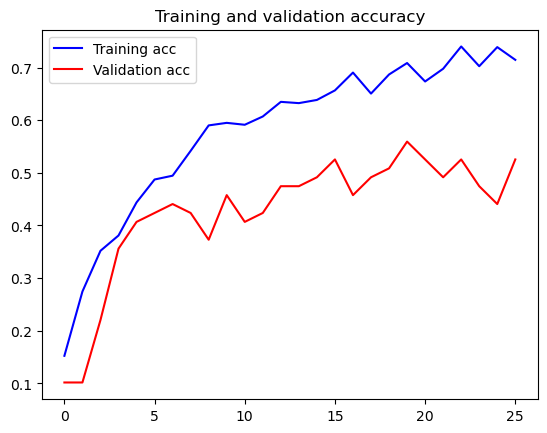

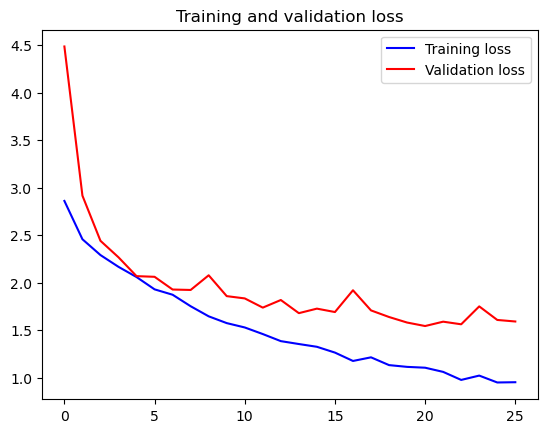

In [15]:
visualize_results(history)

In [16]:
test_generator = test_datagen.flow_from_dataframe(
validate_filenames=False,
dataframe = test_df,
directory = '',
x_col = 'Images',
y_col = 'Class',
class_mode = 'categorical',
batch_size = 20,
target_size=(224,224))

model = load_model(filepath)
yhat = np.argmax(model.predict(test_generator), axis=1)

Found 290 non-validated image filenames belonging to 20 classes.
15/15 [==============================] - 37s 2s/step


In [17]:
ytrue = np.asarray([x[0] for x in test_df['Class']])
print(accuracy_score(ytrue, yhat)*100)
print(precision_score(ytrue, yhat, average='micro')*100)
print(recall_score(ytrue, yhat, average='micro')*100)
print(f1_score(ytrue, yhat, average='micro')*100)

4.827586206896552
4.827586206896552
4.827586206896552
4.827586206896552


In [7]:
vgg_conv = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape=(224, 224, 3))
for layer in vgg_conv.layers[:-1]:
    layer.trainable = False

for layer in vgg_conv.layers:
    print(layer, layer.trainable)
filepath = 'vgg_16_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
es = es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model = Sequential()
model.add(vgg_conv)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(20, activation='softmax'))
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])
 
model.summary()

2022-12-09 16:41:15.149766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<keras.engine.input_layer.InputLayer object at 0x7fd190707ac0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fd1a0e9d070> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fd1c565c040> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fd190704b80> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fd1a0e9ec70> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fd1c5643430> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fd180592b80> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fd180592850> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fd1c564ac10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fd180599ee0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fd180599bb0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fd1c564a2b0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fd18059e850> False
<keras.layers.convolut

In [8]:
history = model.fit(
      train_generator,
      steps_per_epoch=
         train_generator.samples/train_generator.batch_size,
      epochs=50,
      validation_data=validation_generator, 
      validation_steps=
         validation_generator.samples/validation_generator.batch_size,
      verbose=1,
      callbacks = [checkpoint, es])

Epoch 1/50
42/41 [==============================] - ETA: -1s - loss: 2.8191 - accuracy: 0.1487
Epoch 1: val_loss improved from inf to 4.54328, saving model to vgg_16_best_model.hdf5
41/41 [==============================] - 116s 3s/step - loss: 2.8191 - accuracy: 0.1487 - val_loss: 4.5433 - val_accuracy: 0.1356
Epoch 2/50
42/41 [==============================] - ETA: -1s - loss: 2.3388 - accuracy: 0.3083
Epoch 2: val_loss improved from 4.54328 to 2.99627, saving model to vgg_16_best_model.hdf5
41/41 [==============================] - 113s 3s/step - loss: 2.3388 - accuracy: 0.3083 - val_loss: 2.9963 - val_accuracy: 0.2203
Epoch 3/50
42/41 [==============================] - ETA: -1s - loss: 2.1264 - accuracy: 0.3857
Epoch 3: val_loss improved from 2.99627 to 2.23588, saving model to vgg_16_best_model.hdf5
41/41 [==============================] - 114s 3s/step - loss: 2.1264 - accuracy: 0.3857 - val_loss: 2.2359 - val_accuracy: 0.3729
Epoch 4/50
42/41 [==============================] - ETA:

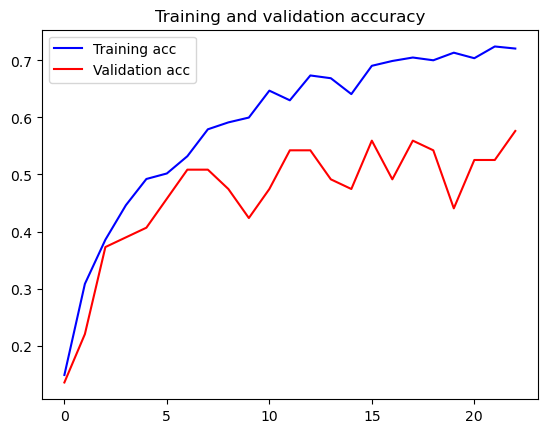

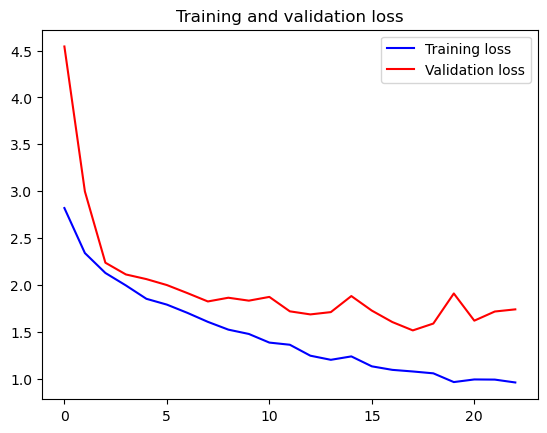

In [9]:
# Run the function to illustrate accuracy and loss
visualize_results(history)

In [10]:
test_generator = test_datagen.flow_from_dataframe(
validate_filenames=False,
dataframe = test_df,
directory = '',
x_col = 'Images',
y_col = 'Class',
class_mode = 'categorical',
batch_size = 20,
target_size=(224,224))

model = load_model(filepath)
yhat = np.argmax(model.predict(test_generator), axis=1)

Found 290 non-validated image filenames belonging to 20 classes.
15/15 [==============================] - 38s 2s/step


In [11]:
ytrue = np.asarray([x[0] for x in test_df['Class']])
print(accuracy_score(ytrue, yhat)*100)
print(precision_score(ytrue, yhat, average='micro')*100)
print(recall_score(ytrue, yhat, average='micro')*100)
print(f1_score(ytrue, yhat, average='micro')*100)

7.241379310344828
7.241379310344828
7.241379310344828
7.241379310344828
